In [1]:

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from joblib import dump, load
import matplotlib.cm as cm
import tensorflow as tf
import numpy as np
import os, cv2
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))
tf.version.VERSION

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


'2.9.1'

In [ ]:
import os
import random
import shutil

def create_dataset(cat = 'images', dir_train = 'train', dir_val = 'val', dir_test = 'test', seed=42):
    # Chemin vers le dossier contenant vos sous-dossiers de données
    data_dir = '../data/COVID-19_Radiography_Dataset/'
    data_dir_output = '../data/'
    # Noms de vos sous-dossiers de données
    categories = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']
    targcat = categories
    # Créer les dossiers de train, test et validation pour chaque catégorie
    for category, targ in zip(categories, targcat):
        os.makedirs(os.path.join(data_dir_output, dir_train, targ), exist_ok=True)
        os.makedirs(os.path.join(data_dir_output, dir_test, targ), exist_ok=True)
        os.makedirs(os.path.join(data_dir_output, dir_val, targ), exist_ok=True)

        # Chemin vers le sous-dossier de la catégorie actuelle
        category_dir = os.path.join(data_dir, category, cat)

        # Lister tous les fichiers d'images dans le sous-dossier de la catégorie
        all_files = os.listdir(category_dir)

        # # Mélanger les fichiers
        random.seed(seed)
        random.shuffle(all_files)

        # Calculer les tailles des ensembles de données
        num_train = int(0.75 * len(all_files))
        num_test = int(0.1 * len(all_files))
        num_val = len(all_files) - num_train - num_test

        # Copier les fichiers dans les ensembles de données
        for i, file_name in enumerate(all_files):
            src_path = os.path.join(category_dir, file_name)
            if i < num_train:
                dst_path = os.path.join(data_dir_output, dir_train, targ, file_name)
            elif i >= num_train and i < num_train + num_test:
                dst_path = os.path.join(data_dir_output, dir_test, targ, file_name)
            else:
                dst_path = os.path.join(data_dir_output, dir_val, targ, file_name)
            shutil.copy(src_path, dst_path)

In [ ]:
create_dataset()

**CREATION DES GENERATEURS DE TRAIN, TEST ET VAL**

In [ ]:
def my_generator(seed, target_size, directory, set_label=[0,1,2,3], categorical=True):
    # Liste des différents types de fichiers à traiter
    Liste = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

    # Récupération des noms de fichiers et des dossiers pour chaque type de fichier
    for index, name in enumerate(Liste):
        for dirname, _, filenames in os.walk(directory.decode() + name):
            if name == 'COVID':
                covid_file = filenames
                covid_dir = dirname
            elif name == 'Normal':
                normal_file = filenames
                normal_dir = dirname
            elif name == 'Lung_Opacity':
                lung_file = filenames
                lung_dir = dirname
            elif name == 'Viral Pneumonia':
                viral_file = filenames
                viral_dir = dirname

    # Copie des noms de fichiers pour les enregistrer et réutiliser les fichiers non lus
    save_covid_file = covid_file.copy()
    save_normal_file = normal_file.copy()
    save_lung_file = lung_file.copy()
    save_viral_file = viral_file.copy()
    
    # Création de listes pour les noms de fichiers, les noms de dossiers et les compteurs
    list_file = [covid_file, normal_file, lung_file, viral_file]
    list_save_file = [save_covid_file, save_normal_file, save_lung_file, save_viral_file]
    list_dir = [covid_dir, normal_dir, lung_dir, viral_dir]
    i = [0,0,0,0]

    # Récupération des classes et du nombre de classes
    classes, card_class = np.unique(set_label, return_counts = True)
    N_maj_class = np.max(card_class)
    maj_class = classes[np.argmax(card_class)]
    N_classes = len(classes)
 
    y = 0
    repeat = 0
    while np.sum(i) < 4:
        for j in range(len(list_file)):
            # Si il ne reste plus de fichiers dans le répertoire, on recharge les fichiers sauvegardés et on les mélange
            if not len(list_file[j]):
                list_file[j] = list_save_file[j].copy()
                np.random.shuffle(list_file[j])
                i[j] = 1

        # Si la classe à lire n'est pas la classe majoritaire, on lit une image et on répète jusqu'à atteindre N_maj_class images
        if set_label[y] != maj_class and repeat < N_maj_class:
            image = cv2.imread(os.path.join(list_dir[y], list_file[y][0]), 0)
            list_file[y].remove(list_file[y][0])
            label = set_label[y]
            repeat+=1

        # Si la classe à lire est la classe majoritaire, on lit une image et on passe à la classe suivante
        elif set_label[y] == maj_class:
            image = cv2.imread(os.path.join(list_dir[y], list_file[y][0]), 0)
            list_file[y].remove(list_file[y][0])
            label = set_label[y]
            y+=1

        # Si on a atteint N_maj_class répétitions, on réinitialise le compteur de répétitions et on passe à la classe suivante
        if repeat >= N_maj_class:
            repeat = 0
            y+=1
        if y >= 4:
            y=0
        
        # Si l'option "categorical" est activée, on convertit le label en un vecteur catégoriel
        if categorical:
            label = tf.keras.utils.to_categorical(label, num_classes=N_classes)
            label = tf.constant(label, shape=(N_classes,))
        
        # Si l'option "categorical" est désactivée, on crée un tenseur avec la valeur du label
        else : 
            label = tf.constant(label, shape=(1,))    
        
        # Redimensionnement de l'image si nécessaire
        if target_size is not None:
            image = cv2.resize(image, target_size)
        
        # Ajout d'une dimension pour la couleur si l'image est en noir et blanc
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)

        # Normalisation de l'image
        image = image.astype("float32") / 255.0

        # Ajout d'un axe pour le lot
        image = tf.expand_dims(image, axis=0)

        yield image, label


In [ ]:
img_size = 299
n_chanel = 1
labels = [0,1,1,1]
cat = True
if cat == True:
        n_classes = len(np.unique(labels))
else: n_classes = 1        
BS = 128
with tf.device('GPU:0'):
        train = tf.data.TFRecordDataset.from_generator(        
                my_generator,
                args=[42, (img_size, img_size), f"../data/train/", labels, cat],
                output_types=(tf.float32, tf.float32),
                output_shapes=((img_size, img_size, n_chanel), (n_classes,))).batch(BS).prefetch(tf.data.AUTOTUNE).cache()
        val= tf.data.TFRecordDataset.from_generator( 
                my_generator,
                args=[42, (img_size, img_size), f"../data/val/", labels, cat],
                output_types=(tf.float32, tf.float32),
                output_shapes=((img_size, img_size, n_chanel), (n_classes,))).batch(BS).prefetch(tf.data.AUTOTUNE).cache()


**GESTION DES CALLBACKS**

In [ ]:
class EarlyStoppingWithEpochStart(tf.keras.callbacks.Callback):
    def __init__(self, patience=0, start = 0):
        super(EarlyStoppingWithEpochStart, self).__init__()
        self.patience = patience
        self.start = start
        # best_weights pour stocker les poids auxquels la perte minimale est atteinte
        self.best_weights = None
        self.best_epoch = 0
        
    def on_train_begin(self, logs=None):
        # le nombre d'époques où il a attendu lorsque la perte n'est plus minimale.
        self.wait = 0
        # l'époque à laquelle l'entraînement s'arrête.
        self.stopped_epoch = 0
        # Initialise la meilleure perte comme l'infini.
        self.bestloss = np.inf
        self.bestacc = 0

    def on_epoch_end(self, epoch, logs=None):
        # On récupère les métriques de validation actuelles
        currentloss = logs.get("val_loss")
        currentacc = logs.get("val_accuracy")
        # On vérifie si on doit commencer l'early stopping
        if epoch >= self.start:
            # Si la perte actuelle est inférieure à la meilleure perte jusqu'à présent
            if np.less(currentloss, self.bestloss) :
                self.bestloss = currentloss
                self.wait = 0
                # On enregistre les meilleurs poids
                self.best_weights = self.model.get_weights()
                self.best_epoch = epoch +1
            # Si l'accuracy actuelle est meilleure que la meilleure accuracy jusqu'à présent
            elif np.less(self.bestacc, currentacc) :
                self.bestacc = currentacc
                self.wait = 0
                # On enregistre les meilleurs poids
                self.best_weights = self.model.get_weights()
                self.best_epoch = epoch +1    
            # Si la perte d'entraînement actuelle est supérieure à la perte de validation actuelle
            # et l'accuracy actuelle est inférieure à l'accuracy d'entraînement
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    # On arrête l'entraînement
                    self.stopped_epoch = epoch
                    self.model.stop_training = True
                    # On restaure les meilleurs poids et on affiche des informations
                    print("Restoring model weights from the end of the best epoch. (Epoch %d)" % (self.best_epoch))
                    print("accuracy : %f" % (self.bestacc))
                    self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            # On affiche un message pour indiquer que l'early stopping a été déclenché
            print("Epoch %d: early stopping" % (self.stopped_epoch + 1))



In [ ]:
reduce_lr_val = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              min_delta=0.001, patience=5, min_lr=0.0000001)

early_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, min_delta=0.001, mode='max', restore_best_weights=True)


class SaveModelOnThreshold(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold
        self.history = {}
        self.best_epoch = 0
        self.best_score = 0

    def on_epoch_end(self, epoch, logs=None):
        # Ajouter les valeurs de logs à l'historique
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)

        if logs['val_accuracy'] >= self.threshold:
            self.model.save("../models/model2")
            self.best_score = logs['val_accuracy']
            self.threshold = self.best_score
            # Sauvegarder l'historique
            dump(self.history, '../models/history_model2')
            self.best_epoch = epoch + 1
        print("\n\nLe meilleur accuracy est de :", self.best_score, "a l'etape", self.best_epoch, "\n\n")

**GESTIONS DES LAYERS PERSONALISER**

In [4]:
class HistNorm(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(HistNorm, self).__init__(**kwargs)

    def call(self, inputs):
        # Normalisation de l'histogramme
        inputs = inputs*255
        # Calcul de l'histogramme des intensités
        hist = tf.histogram_fixed_width(inputs, [0, 1], nbins=256)
        # Calcul de la somme cumulative de l'histogramme
        cumsum = tf.cumsum(hist)
        # Normalisation de la somme cumulative
        cumsum = tf.cast(cumsum, tf.float32) / (tf.cast(tf.reduce_prod(tf.shape(inputs)), tf.float32) - 1)
        # Mappage des intensités vers leurs nouvelles valeurs normalisées
        output_pixel = inputs * cumsum[-1] 
        output_pixel = output_pixel/255
        return output_pixel

    def get_config(self):
        config = super(HistNorm, self).get_config()
        return config

    
class EdgeEnhancementFilter(tf.keras.layers.Layer):
    def __init__(self, kernel_size, alpha, **kwargs):
        super(EdgeEnhancementFilter, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.alpha = alpha
        self.kernel = tf.constant([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=tf.float32, shape=(3, 3, 1, 1))

    def call(self, inputs):
        edge = tf.nn.conv2d(inputs, self.kernel, strides=[1, 1, 1, 1], padding='SAME')
        enhanced = inputs + self.alpha * edge
        return enhanced

    def get_config(self):
        config = super(EdgeEnhancementFilter, self).get_config()
        config.update({'kernel_size': self.kernel_size, 'alpha': self.alpha})
        return config

In [ ]:
def skip_mult(x, y, dim1, dim2, dim3):
  x = tf.keras.layers.Resizing(int(dim1), int(dim2))(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.RepeatVector(dim3)(x) 
  x = tf.keras.layers.Reshape([int(dim1), int(dim2), int(dim3)])(x)
  out = tf.keras.layers.Add()([x,y])
  return out

**GESTION DU MODEL1 (From scratch)**

In [ ]:
targ_size_img = 256
inter_size = 128
dim = 16
kernel_len = 4
N = 4

# Chagement du model unet
unet = tf.keras.models.load_model('../models/model_unet/')
unet.trainable = False

In = tf.keras.layers.Input((299,299,1))
x = tf.keras.layers.experimental.preprocessing.Resizing(256,256)(In)
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x)

unet_in = unet.get_layer('conv2d_816').input

unet_output = unet.output

mod = tf.keras.Model(unet_in, unet_output)
mod.trainable = False
u = mod(x)

x = tf.keras.layers.Multiply(name='mask')([x, tf.round(u)])


x = HistNorm()(x)
x= tf.keras.layers.RandomFlip("horizontal")(x)
x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)(x)

for i in range(N):
    x = tf.keras.layers.SeparableConv2D(dim*(2**(i)), kernel_len, 
                      padding='same',
                      depth_multiplier = 2,  
                      use_bias=False,
                      name = 'SepConv2D_1_' +str(i),
                      )(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.SeparableConv2D(dim*(2**(i)), kernel_len, 
                      padding='same',
                      depth_multiplier = 2,    
                      use_bias=False,
                      name = 'SepConv2D_2_' +str(i)
                      )(x)
    x = tf.keras.layers.Activation('relu')(x) 
    
    if i < N-1:
        x = tf.keras.layers.MaxPooling2D(2,2, padding='same')(x)

x = tf.keras.layers.GlobalMaxPooling2D()(x) 
      
x = tf.keras.layers.Dense(16, activation = "relu")(x) 

Out = tf.keras.layers.Dense(n_classes, activation = "softmax")(x)

with tf.device('GPU:0'):
    Model1 = tf.keras.Model(inputs = In, outputs = Out )
Model1.summary()

In [ ]:

tf.config.optimizer.set_jit(True)

Opt = tf.keras.optimizers.Adam()
 
LRscheduler = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.2, patience = 3, verbose = 1)

class_weights = {0:3, 1:1}
Model1.compile(optimizer=Opt,
                loss= tf.keras.losses.CategoricalCrossentropy(),
             
                metrics=['accuracy', tf.keras.metrics.Recall(class_id = 0),  tf.keras.metrics.Precision(class_id = 0)])

history = Model1.fit(train,
                        validation_data= val,
                          callbacks=[EarlyStoppingWithEpochStart(patience = 5, start = 5), LRscheduler],epochs=100)
                           
                       

**GESTION DU MODEL2 (Fine tuned)**

In [ ]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


size_img = 224

my_unet = tf.keras.models.load_model('../models/model_unet224/')
my_unet.trainable = False

In = tf.keras.layers.Input((None,None,1))

inp = tf.keras.layers.experimental.preprocessing.Resizing(size_img, size_img)(In)
inp = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inp)

unet_in = my_unet.get_layer('conv2d_152').input
unet_output = my_unet.output
mod = tf.keras.Model(unet_in, unet_output)
output_model_unet = mod(inp)

x = tf.keras.layers.Multiply(name='mask')([inp, tf.round(output_model_unet)])


x = HistNorm()(x)
x = tf.keras.layers.RandomFlip()(x)
x = tf.keras.layers.concatenate([tf.image.adjust_brightness(x, delta=0.4) , EdgeEnhancementFilter(kernel_size=3, alpha=0.4)(x), x])

xception = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False, input_tensor=None, classes=4, classifier_activation=False)

# xception.trainable = False

xception_in = xception.input
xception_out = xception.layers[45].output

model_xception = tf.keras.Model(xception_in, xception_out)
output_model_xception = model_xception(x)

x = tf.keras.layers.SeparableConv2D(filters=1536, kernel_size=5, strides=1, padding='same', name='before_last_conv2d')(output_model_xception)
x = tf.keras.layers.BatchNormalization(name='block14_sepconv1_bn')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Activation('relu', name='block14_sepconv1_act')(x)
x = tf.keras.layers.SeparableConv2D(filters=2048, kernel_size=3, strides=1, padding='same', name='grad')(x)
x = tf.keras.layers.BatchNormalization(name='block14_sepconv2_bn')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Activation('relu', name='block14_sepconv2_act')(x)
x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
x = tf.keras.layers.Dense(4, activation='relu')(x)
output = tf.keras.layers.Dense(units=4, activation='softmax', name='output')(x)

model2 = tf.keras.models.Model(inputs=In, outputs=output)

call = SaveModelOnThreshold(.9)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(optimizer=opt, loss=tf.keras.losses.KLDivergence(), metrics=['accuracy'])
history = model2.fit(train, validation_data=val, callbacks=[reduce_lr_val, call], workers=-1, epochs=500)

**GESTION DE LA SAUVEGARDE ET LE CHARGEMENT DES MODEL ET HISTORY ICI**

In [35]:

# Model1.save('../models/model2')
# dump(history.history, '../models/history_model1')

# Model1 = tf.keras.models.load_model('../models/model1')

Model2 = tf.keras.models.load_model('./model2/')
# history = load('./history_model26')
# np.max(history['val_accuracy'])

**AFFICHAGE DES COURBES D'APPRENTISSAGE DE HISTORY**

In [ ]:
if history:
    fig = plt.figure(figsize=(15,5))
    fig.set_facecolor('lavender')
    ax = plt.axes()
    ax.set_facecolor("lightcyan")
    plt.title("Evolution de l'erreur par époque", color='b', fontsize=22)
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel("Nombres d'époques", color='m', fontsize=15)
    plt.ylabel("Valeur de perte par CategoricalCrossentropy", color='m', fontsize=15)
    plt.legend()
    plt.savefig("../images/loss.png", bbox_inches="tight")
    plt.show()

    fig = plt.figure(figsize=(15,5))
    fig.set_facecolor('lavender')
    ax = plt.axes()
    ax.set_facecolor("lightcyan")
    plt.suptitle(f"Evolution de l'accuracy par époque", color='b', fontsize=22)
    plt.plot(history['accuracy'], label='accuracy')
    ax = plt.plot(history['val_accuracy'], label='val_accuracy')
    plt.xlabel("Nombres d'époques", color='m', fontsize=15)
    plt.ylabel("Valeur de l'accuracy", color='m', fontsize=15)
    plt.legend()
    plt.savefig("../images/accuracy.png", bbox_inches="tight")
    plt.show()

**PREDICTION SUR L'ENSSEMBLE DE TEST MODEL1**

In [45]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test = test_datagen.flow_from_directory(
        "../data/test/",
        color_mode = "grayscale",
        target_size=(299, 299),
        batch_size=1056,
        class_mode='categorical'
        #shuffle=True
)
répétition = 0
for images, labels in test:
        treshold = 0.8
       
        
        predictions = Model1.predict(images)
        labels = np.argmax(labels, axis = -1)
        
        labels[labels > 0] = 1
   
        predictions[:,0][predictions[:,0] > treshold] = 1
        predictions[:,0][predictions[:,0] <= treshold] = 0
    
        predictions = np.argmax(predictions, axis = -1)
        predictions[predictions > 0] = 1
        
        accuracy = accuracy_score(labels, predictions)
        print('Accuracy: {:.2f}%'.format(accuracy * 100))
        print()
        print()
        # Afficher la matrice de confusion
        cmatrix = confusion_matrix(labels, predictions)
        print('Confusion matrix:')
        print(cmatrix)
        print()
        print()
        print(classification_report(labels, predictions))

        répétition +=1
        if répétition == 1:
             break

Found 2115 images belonging to 4 classes.
33/33 [==============================] - 2s 62ms/step
Accuracy: 97.82%


Confusion matrix:
[[165  12]
 [ 11 868]]


              precision    recall  f1-score   support

           0       0.94      0.93      0.93       177
           1       0.99      0.99      0.99       879

    accuracy                           0.98      1056
   macro avg       0.96      0.96      0.96      1056
weighted avg       0.98      0.98      0.98      1056



**PREDICTION SUR L'ENSSEMBLE DE TEST MODEL2**

In [49]:
model = Model2

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test = test_datagen.flow_from_directory(
        "../data/test/",
        color_mode = "grayscale",
        target_size=(299, 299),
        batch_size=2115,
        class_mode='categorical'
        #shuffle=True
)

for images, y_true in test:
    y_pred = model.predict(images)
    y_pred = np.argmax(y_pred, axis=1)
  
    y_true = tf.argmax(y_true, axis=1)
    y_true = tf.where(tf.equal(y_true, 0), 0, 1)

    accuracy = accuracy_score(y_true, y_pred)
    print('Accuracy: {:.2f}%'.format(accuracy * 100))
    print()
    print()

    # # Afficher la matrice de confusion
    conf = confusion_matrix(y_true, y_pred)
    print('Confusion matrix:')
    print(conf)
    print()
    print()
    print('classification report:')
    print(classification_report(y_true, y_pred))
    break

Found 2115 images belonging to 4 classes.
67/67 [==============================] - 4s 61ms/step
Accuracy: 97.78%
Confusion matrix:
[[ 337   24]
 [  23 1731]]
classification report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       361
           1       0.99      0.99      0.99      1754

    accuracy                           0.98      2115
   macro avg       0.96      0.96      0.96      2115
weighted avg       0.98      0.98      0.98      2115



**CREATION DES DATSET TRAIN, VAL ET TEST POUR LES MASQUES**

In [ ]:
cat = 'masks'
dir_train = 'train_masks'
dir_val = 'val_masks'
dir_test = 'test_masks'

create_dataset(cat, dir_train, dir_val, dir_test)

**CODE POUR AFFICHER LES MASQUES PREDIS PAR LE UNET**

In [74]:
def display(display_list, num):
  fig, axs = plt.subplots(nrows=num, ncols=4, sharex=True, sharey=True, figsize=(15,3*num))
  fig.set_facecolor('lavender')

  title = ['Image', 'Masque', 'Masque prédit', 'Image masquée']
  if num > 1:
    for n in range(num):
      for i in range(len(display_list)):
        axs[n,i].set_title(title[i], color='g')
        axs[n,i].imshow(np.squeeze(display_list[i][n]*255), cmap = 'gray')
  else:
    for i in range(len(display_list)):
        axs[i].set_title(title[i], color='g')
        axs[i].imshow(np.squeeze(display_list[i]*255), cmap = 'gray')

  plt.xticks([])
  plt.yticks([])

  plt.savefig(f"../images/pred_mask.png", bbox_inches="tight")
  plt.show()

def show_predictions(dataset, model, num=1):
    for image, mask in dataset:
      pred_mask = model.predict(image)
      display([image[:num], mask[:num], np.round(pred_mask[:num]), np.multiply(np.round(pred_mask[:num]), image[:num])], num)
      break

Found 421 images belonging to 4 classes.
Found 421 images belonging to 4 classes.


2023-03-08 00:52:42.416686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 621ms/step


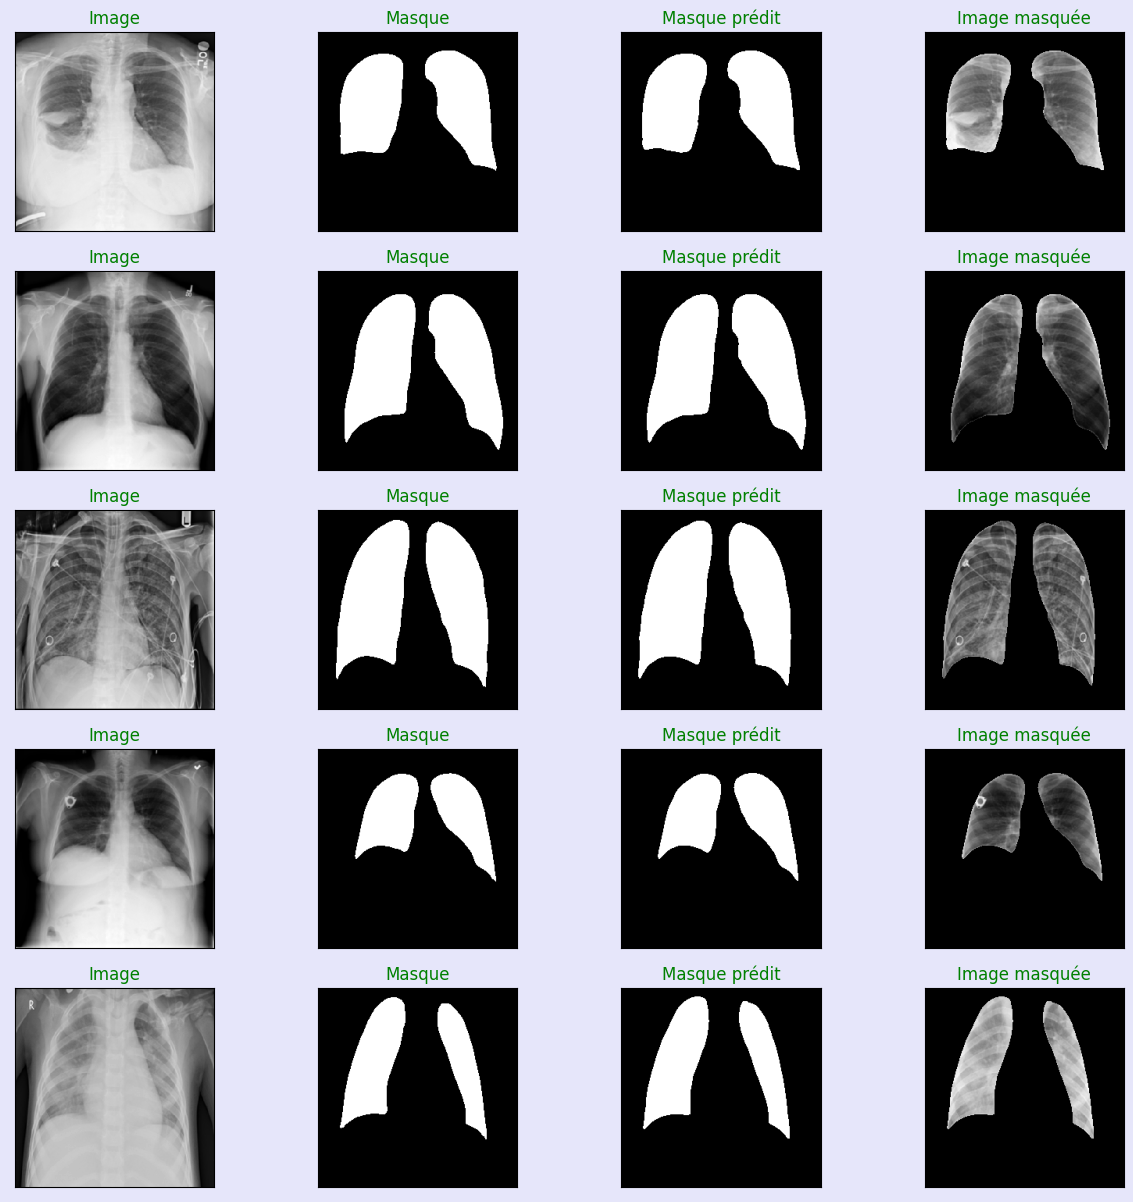

In [75]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                # CHARGE TON UNET ICI SI PAS FAIS PLUS HAUT (ATTENTION AU CHEMIN)
unet = tf.keras.models.load_model("../models/model_unet/")
unet.trainable = False
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

seed = 42
BS = 32

image_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

mask_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

image_generator2 = image_datagen.flow_from_directory("../data/test/",
                                                    class_mode=None, color_mode = "grayscale", 
                                                    target_size=(256, 256),
                                                   seed=seed, batch_size=BS, subset="validation")

mask_generator2 = mask_datagen.flow_from_directory("../data/test_masks//",
                                                   class_mode=None, color_mode = "grayscale",
                                                   target_size=(256, 256),
                                                  seed=seed, batch_size=BS, subset="validation")

test_generator = zip(image_generator2, mask_generator2)
show_predictions(test_generator, unet, 5)

**GESTION ET AFFICHAGE DU GRADCAM**

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Tout d'abord, nous créons un modèle qui mappe l'image d'entrée aux activations
    # de la dernière couche convolutive ainsi que les prédictions de sortie
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Ensuite, nous calculons le gradient de la classe prédite supérieure pour notre image d'entrée
    # par rapport aux activations de la dernière couche convolutive
    with tf.GradientTape() as tape2:
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        # C'est le gradient de la sortie neuronale (prédite supérieure ou choisie)
        # par rapport à la carte de caractéristiques de sortie de la dernière couche convolutive
        grads = tape.gradient(class_channel, last_conv_layer_output)
    grads2 = tape2.gradient(grads, last_conv_layer_output )

    # Ceci est un vecteur où chaque entrée est l'intensité moyenne du gradient
    # sur un canal spécifique de la carte de caractéristiques
    pooled_grads = tf.reduce_mean(grads2, axis=(0, 1, 2))
    pooled_grads, _ = tf.clip_by_global_norm([pooled_grads], clip_norm=1.0)

    # Nous multiplions chaque canal dans le tableau de carte de caractéristiques
    # par "l'importance de ce canal" par rapport à la classe prédite supérieure
    # puis nous additionnons tous les canaux pour obtenir l'activation de classe heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    pooled_grads = pooled_grads[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Pour la visualisation, nous allons également normaliser la heatmap entre 0 et 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
import matplotlib.cm as cm

# Applique a heatmap a l'image
def get_superposed_img(image, heatmap, index=0, pred=0, cam_path="cam.jpg", alpha=0.4):

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + image
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

2023-03-08 00:53:02.094485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-08 00:53:02.206972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-08 00:53:02.584489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-08 00:53:02.709078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-08 00:53:02.832489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-08 00:53:02.935223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-08 00:53:03.260307: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 40ms/step


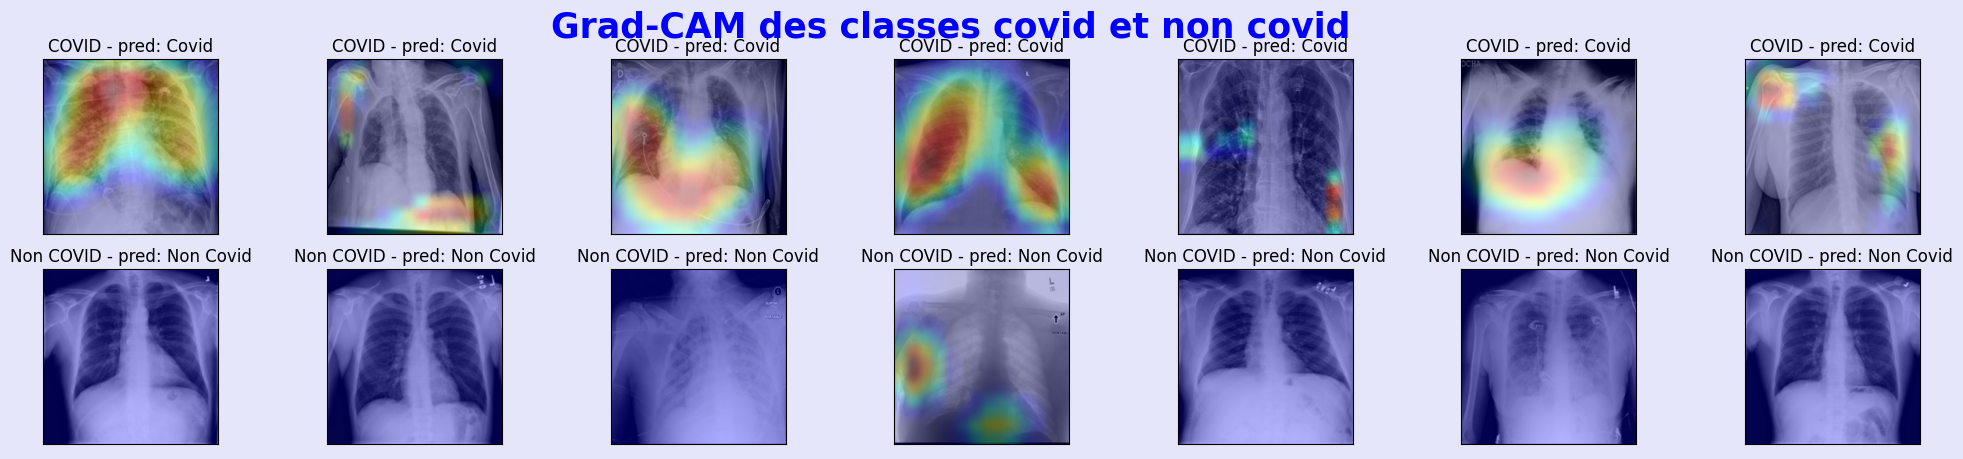

In [76]:
# choisi le model a utiliser
model = Model2

# Affichage de 4 gradcam par categories
for images, labels in test:
    n_col=7
    img = images[0]
    labels = np.argmax(labels, axis=1)
    l0 = []
    l1 = []
    for i in range(len(labels)):
        if len(l0) < n_col and labels[i] == 0:
            l0.append(i)
        if len(l1) < n_col and labels[i] != 0:
            l1.append(i)
        if len(l0) + len(l1) < 8:
            continue


    fig, axs = plt.subplots(nrows=2, ncols=n_col, sharex=True, sharey=True, figsize=(25,5))

    for j, i in enumerate(l0):
        img = images[i]
        index = 0
        # redimensionne l'image si nécessaire
        img = tf.image.resize(img, (224,224))
        img = np.expand_dims(img, axis=0)
        # heatmap =  make_gradcam_heatmap(img, model, 'separable_conv2d_31', index)
        heatmap =  make_gradcam_heatmap(img, model, 'grad', index)
        pred = model.predict(img)
        pred = np.argmax(pred, axis=1)[0]
        image = get_superposed_img(img[0], heatmap, index, pred)
        axs[0,j].set_title(f"COVID - pred: {'Covid' if pred == 0 else 'Non Covid'}")
        axs[0,j].imshow(image, cmap='gray', vmin=0, vmax=255)

    for j, i in enumerate(l1):
        img = images[i]
        index = 1
        # redimensionne l'image si nécessaire
        img = tf.image.resize(img, (224,224))
        img = np.expand_dims(img, axis=0)
        # heatmap =  make_gradcam_heatmap(img, model, 'separable_conv2d_31', index)
        heatmap =  make_gradcam_heatmap(img, model, 'grad', index)
        pred = model.predict(img)
        pred = np.argmax(pred, axis=1)[0]
        image = get_superposed_img(img[0], heatmap, index, pred)
        axs[1,j].set_title(f"Non COVID - pred: {'Covid' if pred == 0 else 'Non Covid'}")
        axs[1,j].imshow(image, cmap='gray', vmin=0, vmax=255)

    plt.xticks([])
    plt.yticks([])
    fig.patch.set_facecolor('lavender')
    plt.suptitle('Grad-CAM des classes covid et non covid', color='b', fontsize='25', fontweight='bold')

    # Enregistrement de la figure en image
    # plt.savefig(f"../images/grad4.png", bbox_inches="tight")

    # Afficher la figure
    plt.show()
    break

**CREATION DES DATASETS DE TRAIN, TEST ET VAL**

**Code pour entrainer un Unet**

In [ ]:
# seed = 42
# BS = 32
# image_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# mask_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# image_generator =image_datagen.flow_from_directory("../data/train/",
#                                                     class_mode=None, color_mode = "grayscale", 
#                                                     target_size=(224, 224),
#                                                    seed=seed, batch_size=BS, subset="training")
# mask_generator = mask_datagen.flow_from_directory("../data/train_masks/",
#                                                    class_mode=None, color_mode = "grayscale",
#                                                    target_size=(224, 224),
#                                                   seed=seed, batch_size=BS, subset="training")

# train_generator = zip(image_generator, mask_generator)


# image_generator2 =image_datagen.flow_from_directory("../data/val/",
#                                                     class_mode=None, color_mode = "grayscale", 
#                                                     target_size=(224, 224),
#                                                    seed=seed, batch_size=BS, subset="validation")

# mask_generator2 = mask_datagen.flow_from_directory("../data/val_masks/",
#                                                    class_mode=None, color_mode = "grayscale",
#                                                    target_size=(224, 224),
#                                                   seed=seed, batch_size=BS, subset="validation")

# val_generator = zip(image_generator2, mask_generator2)


# def conv_block(inputs, filters, pool=True):
#     x = tf.keras.layers.Conv2D(filters, 3, padding="same")(inputs)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation("relu")(x)

#     x = tf.keras.layers.Conv2D(filters, 3, padding="same")(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation("relu")(x)

#     if pool == True:
#         p = tf.keras.layers.MaxPool2D((2, 2))(x)
#         return x, p
#     else:
#         return x
    
# def build_unet(shape, num_classes):
#     inputs = tf.keras.layers.Input(shape)

#     """ Encoder """
#     x1, p1 = conv_block(inputs, 16, pool=True)
#     x2, p2 = conv_block(p1, 32, pool=True)
#     x3, p3 = conv_block(p2, 48, pool=True)
#     x4, p4 = conv_block(p3, 64, pool=True)

#     """ Bridge """
#     b1 = conv_block(p4, 128, pool=False)

#     """ Decoder """
#     u1 = tf.keras.layers.UpSampling2D((2, 2), interpolation="bilinear")(b1)
#     c1 = tf.keras.layers.Concatenate()([u1, x4])
#     x5 = conv_block(c1, 64, pool=False)

#     u2 = tf.keras.layers.UpSampling2D((2, 2), interpolation="bilinear")(x5)
#     c2 = tf.keras.layers.Concatenate()([u2, x3])
#     x6 = conv_block(c2, 48, pool=False)

#     u3 = tf.keras.layers.UpSampling2D((2, 2), interpolation="bilinear")(x6)
#     c3 = tf.keras.layers.Concatenate()([u3, x2])
#     x7 = conv_block(c3, 32, pool=False)

#     u4 = tf.keras.layers.UpSampling2D((2, 2), interpolation="bilinear")(x7)
#     c4 = tf.keras.layers.Concatenate()([u4, x1])
#     x8 = conv_block(c4, 16, pool=False)

#     """ Output layer """
#     output = tf.keras.layers.Conv2D(num_classes, 1, padding="same", activation="sigmoid")(x8)

#     return tf.keras.models.Model(inputs, output)


# shape = (224, 224, 1)
# num_classes = 1
# model_unet = build_unet(shape, num_classes)

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, min_delta=0.001, patience=4, min_lr=0.000001)

# reduce_lr_val = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_delta=0.001, patience=4, min_lr=0.000001)

# batch = image_generator.batch_size
# size = image_generator.samples
# batch2 = mask_generator.batch_size
# size2 = mask_generator.samples

# opt = tf.optimizers.Adam(learning_rate=0.01)
# model_unet.compile(optimizer = opt,loss= tf.keras.losses.BinaryCrossentropy(from_logits=False) ,metrics=['accuracy'])
# early_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, min_delta=0.001, mode='max', restore_best_weights=True)
# history = model_unet.fit(train_generator, steps_per_epoch = size//batch, validation_data=val_generator, callbacks=[reduce_lr, early_stoping], validation_steps=size2/batch2, epochs = 100)